# Phase 1 - Ingestion and Cleaning

In the Phase 2 of the Case Study, we will carry out the following steps:
  - Ingest raw downloaded data
  - Output a combined dataset ready for analysis and modeling

In [1]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn
import warnings #ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# A helper function that you'll be using while reading the raw files
def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False

## Parameters

In [36]:
# Define the directories that contain the files downloaded
dir_cs = "/case_study_data.zip" # path to the directory where all the *.csv.zip files are located

# Define the output path for the pickle
pickle_file = "loanData/" + "allFeatures.pickle" # path to save cleaned data

In [13]:
# Identify the columns we'll be keeping from the dataset
# list of features to use for this study as indicated in the handout
cols_to_pick = ['funded_amnt_inv', 'last_pymnt_amnt', 'application_type', "id", "loan_amnt", "funded_amnt", "term", "int_rate", "installment", "grade", "emp_length", \
                "home_ownership", "annual_inc", "verification_status", "issue_d", "loan_status", "purpose", \
                "dti", "delinq_2yrs", "earliest_cr_line", "open_acc", "pub_rec","fico_range_high", "fico_range_low", \
                "revol_bal", "revol_util", "total_pymnt", "last_pymnt_d", "recoveries"] 

# Identify the type of each of these column based on your CS-Phase 1 response
float_cols = ['last_pymnt_amnt', 'funded_amnt_inv', "loan_amnt", "funded_amnt", "installment", "annual_inc", "dti", "delinq_2yrs", "open_acc", "pub_rec", \
              "fico_range_high", "fico_range_low", "revol_bal", "total_pymnt", "recoveries"]
cat_cols = ['application_type', "term", "grade", "emp_length", "home_ownership", "verification_status", "loan_status", "purpose"] # categorical features
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

#did not iclude: sub_grade, emp title, 'title', zip code, addr state


# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

In [14]:
# Some of the columns selected will not be used directly in the model,
# but will be used to generate other features.
#
# Create variables specifying the features that will be used

# All categorical columns other than "loan_status" will be used as
# discrete features

discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

## Ingestion
Ingest the data files from both sets, perform consistency checks, and prepare one single file for each set

In [7]:
import glob

def ingest_files(directory):
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.
    
    We assume the directory contains files directly downloaded from
    the link given in the handout, and *only* those files. Thus, we 
    assume the files are zipped (pd.read_csv can read zipped files) 
    and we assume the first line in each file needs to be skipped.
    
    Note that each file will be read *without* formatting
    '''
    
    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory += "/"
    
    all_files = glob.glob(directory+"*.zip") # get list of all files from the directory
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + i)
        output[i] = pd.read_csv(i, dtype='str', skiprows=1) # read each with dtype='str' and skip_rows =1
        
        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        invalid_rows = [not is_integer(r) for r in output[i]['id']] # mask rows that have non-integer IDs. Use is_integer method
       
        if sum(invalid_rows) > 0:
            print("Found " + str(sum(invalid_rows)) + " invalid rows which were removed")
            output[i] = output[i][np.logical_not(invalid_rows)] # remove invalid rows
    
    return output # return dictionary of dataframe

In [8]:
# Ingest the set of files we downloaded using the defined method "ingest_files"
files_cs = ingest_files("case_study_data/1805_download") # dictionary of (filename, dataframe) as (key, value)

Directory case_study_data/1805_download/ has 12 files:
    Reading file case_study_data/1805_download\LoanStats3a_securev1.csv.zip
Found 3 invalid rows which were removed
    Reading file case_study_data/1805_download\LoanStats3b_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file case_study_data/1805_download\LoanStats3c_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file case_study_data/1805_download\LoanStats3d_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file case_study_data/1805_download\LoanStats_securev1_2016Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file case_study_data/1805_download\LoanStats_securev1_2016Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file case_study_data/1805_download\LoanStats_securev1_2016Q3.csv.zip
Found 2 invalid rows which were removed
    Reading file case_study_data/1805_download\LoanStats_securev1_2016Q4.csv.zip
Found 2 invalid rows which were remov

### Combine the files

In [15]:
data_cs = pd.concat(files_cs.values()) # combine "files_cs" into a pandas dataframe
data_cs.reset_index(drop=True)          # reset index with drop = True
data_cs.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,1077501,NaN,5000,5000,4975,36 months,10.65%,162.87,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,NaN,2500,2500,2500,60 months,15.27%,59.83,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,NaN,2400,2400,2400,36 months,15.96%,84.33,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,NaN,10000,10000,10000,36 months,13.49%,339.31,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,NaN,3000,3000,3000,60 months,12.69%,67.79,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## Prepare Final Dataset

In [16]:
# Keep only the columns of interest from 'data_cs'
final_data = data_cs[cols_to_pick]
final_data.shape

(1765426, 29)

In [17]:
print("Starting with " + str(len(final_data)) + " rows")

Starting with 1765426 rows


### Typecast the columns

In [18]:
# Remember that we read the data as string (without any formatting). 
# Now we would typecast the columns based on feature types which you found out in CS Phase 1

for i in float_cols:
    final_data[i] = final_data[i].astype(float) # typecast float columns
    
final_data.dtypes

C:\Users\josep\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


funded_amnt_inv        float64
last_pymnt_amnt        float64
application_type        object
id                      object
loan_amnt              float64
funded_amnt            float64
term                    object
int_rate                object
installment            float64
grade                   object
emp_length              object
home_ownership          object
annual_inc             float64
verification_status     object
issue_d                 object
loan_status             object
purpose                 object
dti                    float64
delinq_2yrs            float64
earliest_cr_line        object
open_acc               float64
pub_rec                float64
fico_range_high        float64
fico_range_low         float64
revol_bal              float64
revol_util              object
total_pymnt            float64
last_pymnt_d            object
recoveries             float64
dtype: object

In [19]:
def clean_perc(x):
    if type(x) is float:
        return x
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])

for i in perc_cols:
    final_data[i] = [clean_perc(j) for j in final_data[i]] # apply clean_perc to percentage columns
    
final_data.dtypes

C:\Users\josep\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


funded_amnt_inv        float64
last_pymnt_amnt        float64
application_type        object
id                      object
loan_amnt              float64
funded_amnt            float64
term                    object
int_rate               float64
installment            float64
grade                   object
emp_length              object
home_ownership          object
annual_inc             float64
verification_status     object
issue_d                 object
loan_status             object
purpose                 object
dti                    float64
delinq_2yrs            float64
earliest_cr_line        object
open_acc               float64
pub_rec                float64
fico_range_high        float64
fico_range_low         float64
revol_bal              float64
revol_util             float64
total_pymnt            float64
last_pymnt_d            object
recoveries             float64
dtype: object

In [20]:
def clean_date(x):
    if type(x) is datetime.datetime:
        return x
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()

for i in date_cols:
    final_data[i] = [clean_date(d) for d in final_data[i]] # typecast date cloumns to datatime using clean_date

C:\Users\josep\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [21]:
for i in cat_cols:
    final_data[i].replace(r'\s+', None, regex=True, inplace = True) # for categorical features if the value is null/empty set it to None

In [22]:
final_data.head().T

,0,1,2,3,4
funded_amnt_inv,4975,2500,2400,10000,3000
last_pymnt_amnt,171.62,119.66,649.91,357.48,67.3
application_type,Individual,Individual,Individual,Individual,Individual
id,1077501,1077430,1077175,1076863,1075358
loan_amnt,5000,2500,2400,10000,3000
funded_amnt,5000,2500,2400,10000,3000
term,36 months,60 months,36 months,36 months,60 months
int_rate,10.65,15.27,15.96,13.49,12.69
installment,162.87,59.83,84.33,339.31,67.79
grade,B,C,C,C,B


## Calculate returns for each loan

In [23]:
# Define the names of the four returns we'll be calculating as described in Q.6
# ret_PESS: Pessimistic return
# ret_OPT: Optimistic return
# ret_INTa, ret_INTb: Method3 at two different values of "i" 
ret_cols = ["ret_PESS", "ret_OPT", "ret_INTa", "ret_INTb"]

In [27]:
# Remove all rows for loans that were paid back on the days they were issued
final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) / np.timedelta64(1, 'M')
n_rows = len(final_data)

#final_data = final_data.loc[final_data['loan_length'] > 0] # select rows where loan_length is not 0. 

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 0 rows


C:\Users\josep\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### M1-Pessimistic Method

In [28]:
final_data.term.str.extract('(\d+)',expand=False).astype(int).head()

0    36
1    60
2    36
3    36
4    60
Name: term, dtype: int32

In [29]:
# Calculate the return using a simple annualized profit margin
# Pessimistic definition (Handout 6a.) (M1)

final_data['term_num'] = final_data.term.str.extract('(\d+)',expand=False).astype(int) # length of loan in months

final_data['ret_PESS'] = ((final_data['total_pymnt']-final_data['loan_amnt'])/final_data['loan_amnt'] ) * (12/final_data['term_num'])

C:\Users\josep\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\josep\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### M2-Optimistic Method

In [30]:
# Assuming that if a loan gives a positive return, we can
# immediately find a similar loan to invest in; if the loan
# takes a loss, we use M1-pessimistic to compute the return

final_data['ret_OPT'] = ((final_data['total_pymnt']-final_data['loan_amnt'])/final_data['loan_amnt'] ) * (12/final_data['loan_length'])

final_data.loc[final_data.ret_OPT < 0,'ret_OPT'] = final_data.loc[final_data.ret_OPT < 0,'ret_PESS']

C:\Users\josep\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\josep\Anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Method 3

In [31]:
def ret_method_3(T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''
    
    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the
    # size of each of these installment
    m = final_data.loan_length
    f = final_data.funded_amnt
    actual_installment = (final_data.total_pymnt - final_data.recoveries) / m #p/m

    # Assuming the amount is immediately re-invested at the prime
    # rate, find the total amount of money we'll have by the end
    # of the loan
    # compute the quantity given in [] in eq.2.3 of handout
    # (p/m) * (1-(1+i)^m) / (1 - (1+i))

    cash_by_end_of_loan = actual_installment * (1-(1+i)**m)/(1-(1+i))
    
    cash_by_end_of_loan = cash_by_end_of_loan + final_data.recoveries
    
    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start
    # of the loan
    remaining_months = T - final_data['loan_length']
    final_return = cash_by_end_of_loan * ((1+i)**remaining_months) - f

    # Find the percentage return
    ret_val = (12/T) * (1/f) * final_return
    return ret_val

In [32]:
final_data['ret_INTa'] = ret_method_3(60,0.001) # call ret_method_3 with T=60, i=0.001
final_data['ret_INTb'] = ret_method_3(60,0.005) # call ret_method_3 with T=60, i=0.005

C:\Users\josep\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\josep\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [33]:
final_data.head().T

,0,1,2,3,4
funded_amnt_inv,4975,2500,2400,10000,3000
last_pymnt_amnt,171.62,119.66,649.91,357.48,67.3
application_type,Individual,Individual,Individual,Individual,Individual
id,1077501,1077430,1077175,1076863,1075358
loan_amnt,5000,2500,2400,10000,3000
funded_amnt,5000,2500,2400,10000,3000
term,36 months,60 months,36 months,36 months,60 months
int_rate,10.65,15.27,15.96,13.49,12.69
installment,162.87,59.83,84.33,339.31,67.79
grade,B,C,C,C,B


### Visualize the variables

In [59]:
def visualize_float_columns(df):
    '''
    This function visualizes Box-and-whisker plots for continuous variables
    '''
    
    # FLoat columns
    for i in float_cols + perc_cols + ret_cols:
        print(i)
        seaborn.boxplot(df[i])

        # Print the three highest values
        highest_vals = list(df[i].sort_values(ascending=False).head(3)) # get 3 highest values
        
        smallest_val = min(df[i])
        
        plt.text(smallest_val, -0.3, highest_vals[0])
        plt.text(smallest_val, -0.2, highest_vals[1])
        plt.text(smallest_val, -0.1, highest_vals[2])

        plt.show()

In [60]:
from collections import Counter
c = Counter(final_data['term'])
c

Counter({' 60 months': 498153, ' 36 months': 1259267})

In [61]:
from collections import Counter
def visualize_cat_columns(df):
    '''
    Lists the distinct values for categorical columns
    '''
    # Categorical columns 
    for i in cat_cols:
        print(i) # print field name
        dataSet = set(df[i])
        print("Number Distinct Values: ", len(dataSet)) # print number of distinct values
        c = Counter(df[i])
        for k,v in c.items():
            print(k,": ",v)# for each distinct value print the number of occurances
        print("")
        print("")

In [62]:
def visualize_date_columns(df):
    '''
    This function visualizes a timeline density for dates
    '''
    
    # Date columns
    for i in date_cols:
        df[df[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts(ascending = True).plot()
        plt.title(i + " (" + str(df[i].isnull().sum()) + " null values)")
        plt.show()

loan_amnt


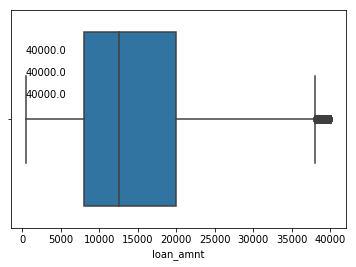

funded_amnt


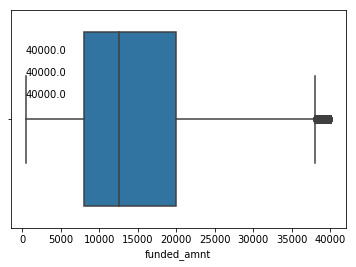

installment


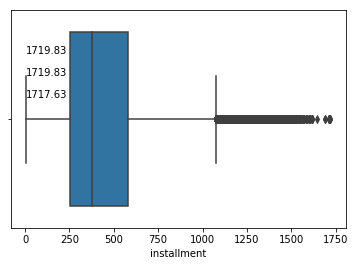

annual_inc


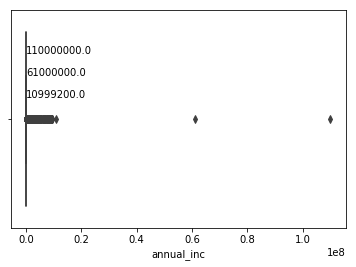

dti


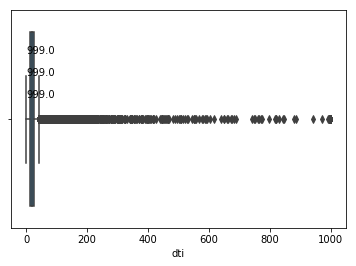

delinq_2yrs


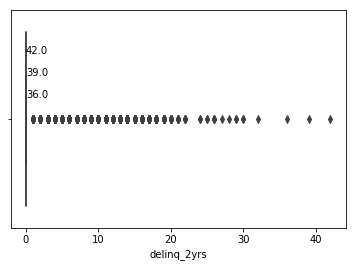

open_acc


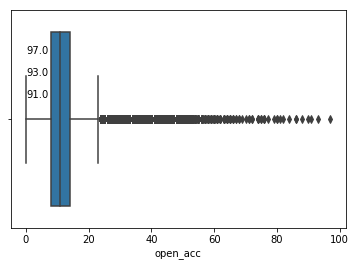

pub_rec


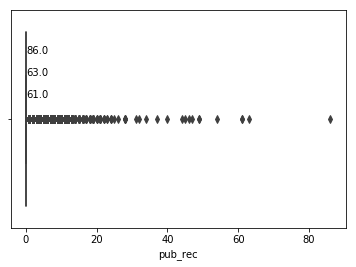

fico_range_high


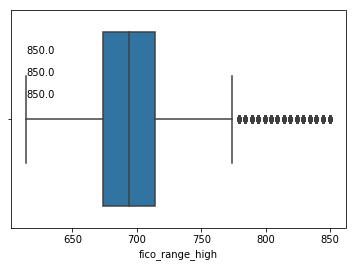

fico_range_low


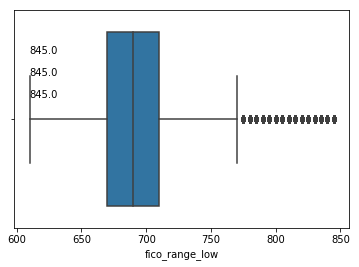

revol_bal


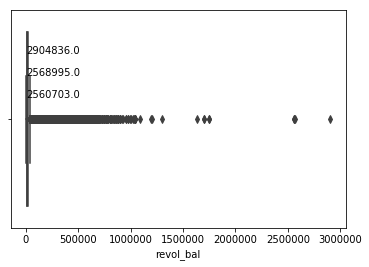

total_pymnt


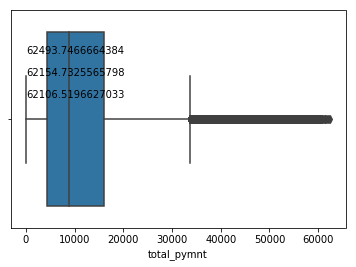

recoveries


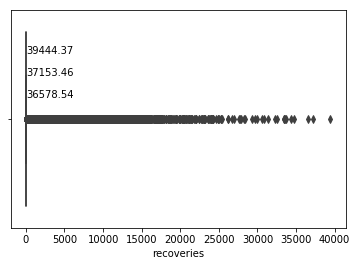

int_rate


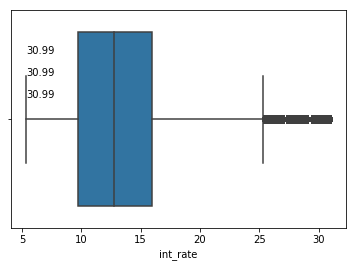

revol_util


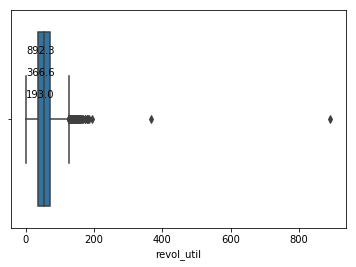

ret_PESS


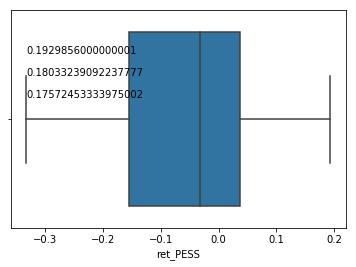

ret_OPT


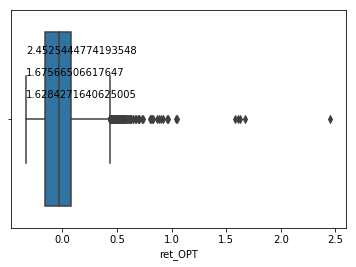

ret_INTa


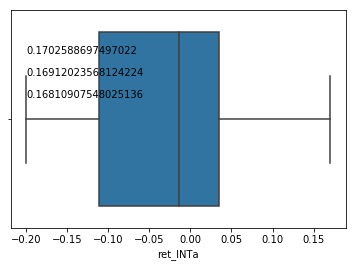

ret_INTb


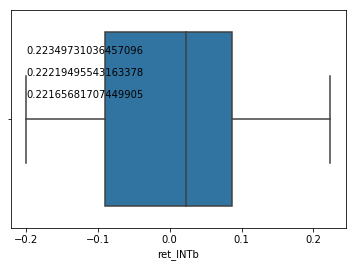

term
Number Distinct Values:  2
 60 months :  498153
 36 months :  1259267


grade
Number Distinct Values:  7
D :  253978
B :  520242
C :  520840
A :  296891
E :  115865
F :  38291
G :  11313


emp_length
Number Distinct Values:  12
9 years :  66460
1 year :  114697
3 years :  139460
< 1 year :  145711
7 years :  74401
10+ years :  585004
nan :  104376
5 years :  108317
8 years :  75562
2 years :  158224
4 years :  104876
6 years :  80332


home_ownership
Number Distinct Values:  6
MORTGAGE :  868757
RENT :  696340
OWN :  191584
ANY :  503
OTHER :  182
NONE :  54


verification_status
Number Distinct Values:  3
Not Verified :  561369
Source Verified :  667628
Verified :  528423


loan_status
Number Distinct Values:  9
Current :  792304
Fully Paid :  736866
Charged Off :  190246
Late (31-120 days) :  20365
Late (16-30 days) :  5758
In Grace Period :  8753
Default :  391
Does not meet the credit policy. Status:Fully Paid :  1988
Does not meet the credit policy. Status:Charged Off :  749


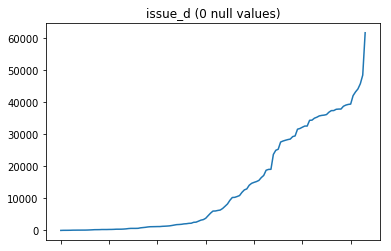

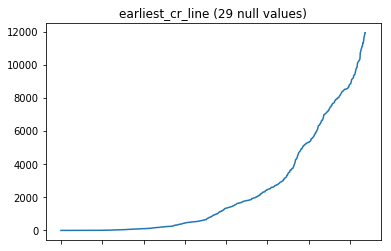

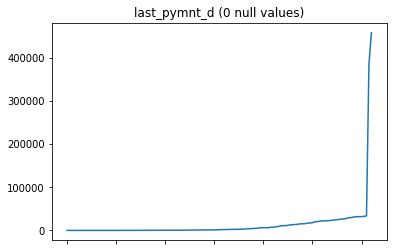

In [63]:
# visualize continuous features
visualize_float_columns(final_data)

# visulaize categorical features
visualize_cat_columns(final_data)

# visualize date columns
visualize_date_columns(final_data)

### Handle outliers

In [64]:
#I want to try and do this using a hat matrix rather than doing feature by feature.  
#let's see how it turns out!

#Don't run this code! will take forever and not finish.

# hat_m = final_data(np.linalg.inv(final_data.T.dot(final_data)).dot(final_data.T))
# hat_v = np.sum(hat_m **2,0)

# plt.scatter(range(len(hat_v)), hat_v, s=1000*hat_v, alpha=0.6)

In [65]:
final_data.shape

(1757420, 32)

max:  892.3
mean:  52.18902954641218
Cutoff:  182.0


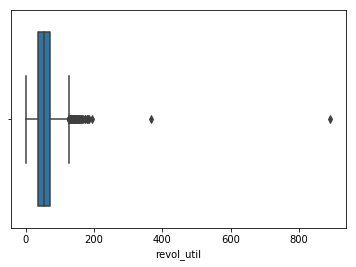

In [66]:
print("max: ",final_data['revol_util'].max())
print("mean: ", final_data['revol_util'].mean())
IQR = (final_data['revol_util'].quantile([.75]).loc[.75] - 
           final_data['revol_util'].quantile([.25]).loc[.25])
print("Cutoff: ",final_data['revol_util'].quantile([.75]).loc[.75]+3*IQR )
seaborn.boxplot(final_data['revol_util'])

In [67]:
# There are quite a few outliers. 
# Please identify top-k (decide this based on the visualization) features where outliers are most obvious
n_rows = len(final_data)

#features that have some major outliers: annual_inc, dti, revol_bal,
#deling_2yrs, open_acc, pub_rec, revol_util, recoveries 

#Basing on 3*IQR+75% percentile as cutoff point

final_data_2 = final_data[final_data['annual_inc']<230_000] #28404 rows removed 
final_data_2 = final_data_2[final_data_2['dti']<62] #31926 (total) rows removed
final_data_2 = final_data_2[final_data_2['revol_bal']<63050] #65512 (total) rows removed
final_data_2 = final_data_2[final_data_2['delinq_2yrs']<10] #66943 (total) rows removed
final_data_2 = final_data_2[final_data_2['open_acc']<=32] #75050 (total) rows removed
final_data_2 = final_data_2[final_data_2['pub_rec']<=10] #75237 (total) rows removed
final_data_2 = final_data_2[final_data_2['revol_util']<=182] #76310 (total) rows removed

print("Removed " + str(n_rows - len(final_data_2)) + " rows")

Removed 76310 rows


max:  180.3
mean:  51.96304818839932
Cutoff:  181.0


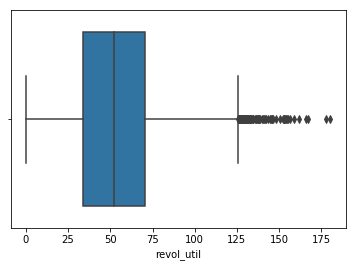

In [68]:
print("max: ",final_data_2['revol_util'].max())
print("mean: ", final_data_2['revol_util'].mean())
IQR = (final_data_2['revol_util'].quantile([.75]).loc[.75] - 
           final_data_2['revol_util'].quantile([.25]).loc[.25])
print("Cutoff: ",final_data_2['revol_util'].quantile([.75]).loc[.75]+3*IQR )
seaborn.boxplot(final_data_2['revol_util'])

In [69]:
Counter(final_data_2['loan_status'])

Counter({'Current': 751927,
         'Fully Paid': 708632,
         'Charged Off': 184457,
         'Late (31-120 days)': 19601,
         'Late (16-30 days)': 5448,
         'In Grace Period': 8293,
         'Default': 379,
         'Does not meet the credit policy. Status:Fully Paid': 1713,
         'Does not meet the credit policy. Status:Charged Off': 660})

In [70]:
# Remove all loans that are still current
n_rows = len(final_data_2)

final_data_2 = final_data_2[~(final_data_2['loan_status']=='Current')]

print("Removed " + str(n_rows - len(final_data_2)) + " rows")

Removed 751927 rows


In [71]:
# Only include loans isssued since 2010
n_rows = len(final_data_2)

final_data_2 = final_data_2[final_data_2['issue_d']>datetime.date(2010, 1, 1)]

print("Removed " + str(n_rows - len(final_data_2)) + " rows")

Removed 8371 rows


### Drop null values

In [35]:
#no data cleaning for this pickle
final_data_2 = final_data

# Deal with null values. We allow cateogrical variables to be null
# OTHER than grade, which is a particularly important categorical.
# All non-categorical variables must be non-null, and we drop
# rows that do not meet this requirement

required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(final_data_2)
    
# drop rows that contain null based only on "required_cols"
final_data_2 = final_data_2.dropna(subset=required_cols)

print("Removed " + str(n_rows - len(final_data_2)) + " rows")
#Note: not sure why this is zero... seems like we don't have any nulls tho.

Removed 3564 rows


### Visualize clean data

loan_amnt


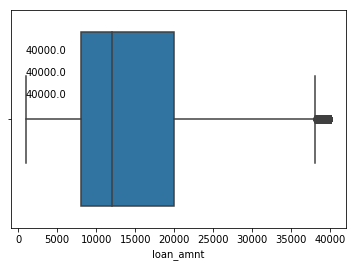

funded_amnt


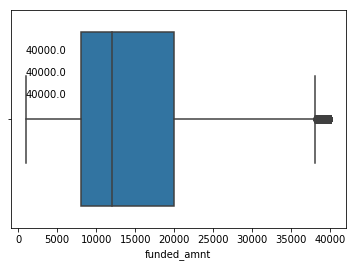

installment


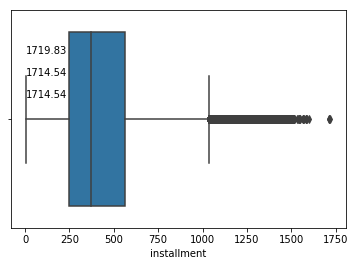

annual_inc


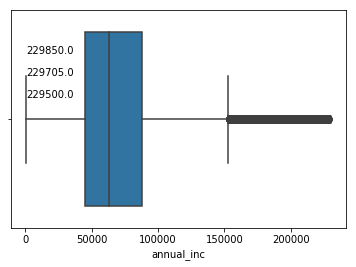

dti


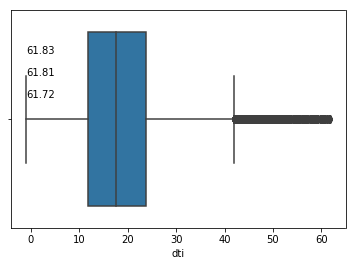

delinq_2yrs


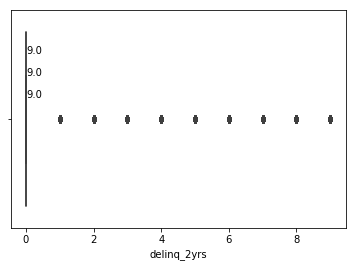

open_acc


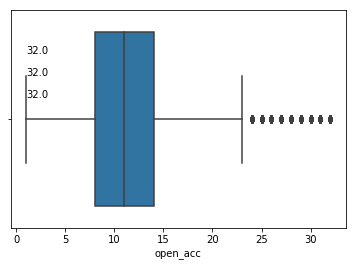

pub_rec


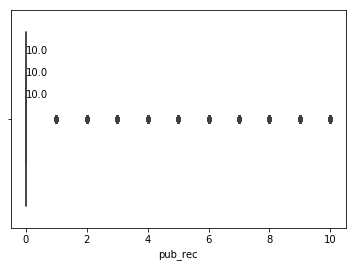

fico_range_high


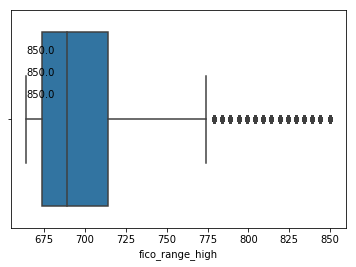

fico_range_low


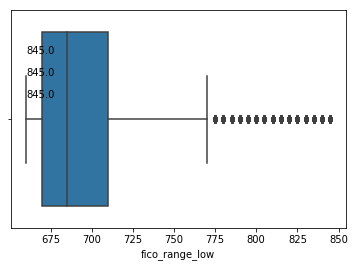

revol_bal


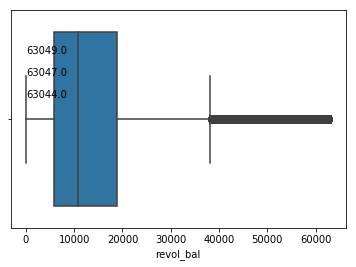

total_pymnt


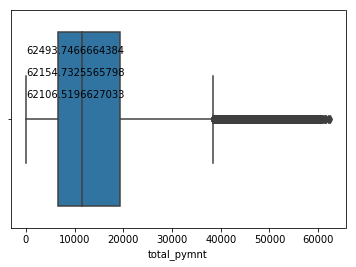

recoveries


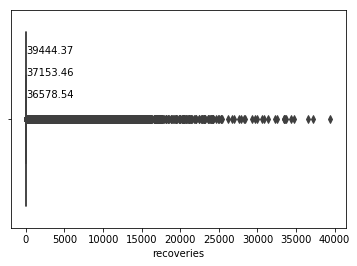

int_rate


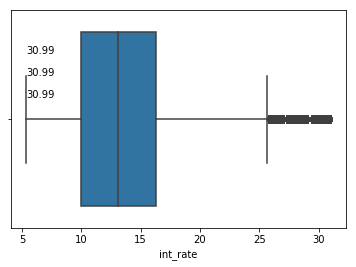

revol_util


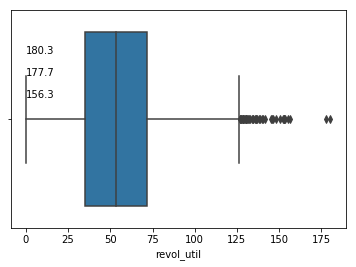

ret_PESS


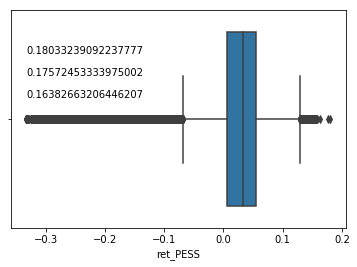

ret_OPT


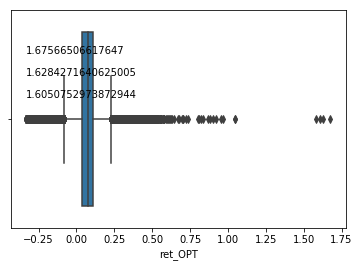

ret_INTa


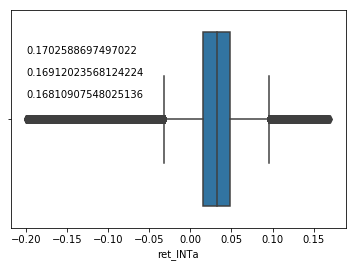

ret_INTb


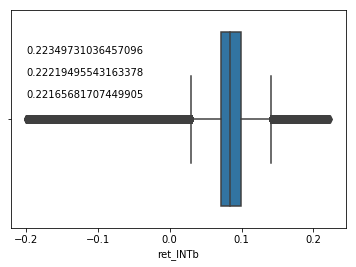

term
Number Distinct Values:  2
 36 months :  694161
 60 months :  226651


grade
Number Distinct Values:  7
B :  263380
A :  146894
C :  260883
D :  145167
E :  71696
G :  7019
F :  25773


emp_length
Number Distinct Values:  12
< 1 year :  73136
nan :  50475
10+ years :  298073
5 years :  58543
2 years :  83531
4 years :  55310
3 years :  73732
8 years :  43430
1 year :  60547
9 years :  35804
7 years :  43398
6 years :  44833


home_ownership
Number Distinct Values:  6
MORTGAGE :  450364
RENT :  376051
OWN :  94174
ANY :  134
OTHER :  46
NONE :  43


verification_status
Number Distinct Values:  3
Not Verified :  283156
Source Verified :  339053
Verified :  298603


loan_status
Number Distinct Values:  8
Fully Paid :  702717
Charged Off :  183552
Late (31-120 days) :  19601
Late (16-30 days) :  5448
In Grace Period :  8293
Default :  379
Does not meet the credit policy. Status:Fully Paid :  591
Does not meet the credit policy. Status:Charged Off :  231


purpose
Number Distinct Value

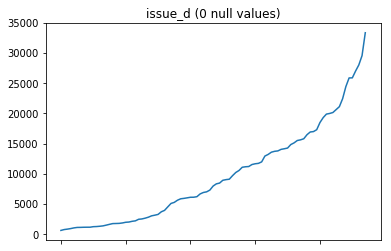

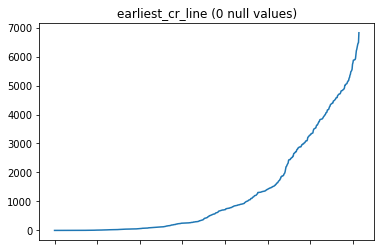

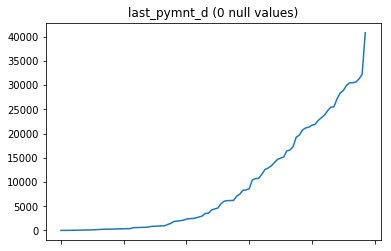

In [73]:
# Visualize the data again after cleaning
# visualize continuous features
visualize_float_columns(final_data_2)

# visulaize categorical features
visualize_cat_columns(final_data_2)

# visualize date columns
visualize_date_columns(final_data_2)

In [74]:
#Note: the 2 cells below take forever/don't complete.. not sure why.  Maybe due to cols_to_pick

In [75]:
# # Visualize the feature correlations
# # use sns scatter or pairplot
# import seaborn as sns
# g = sns.pairplot(data=final_data_2, vars=float_cols,
#             diag_kind=None)# , plot_kws={'scatter_kws': {'alpha': 0.3}})
# g.set(alpha=0.1)
# plt.show()

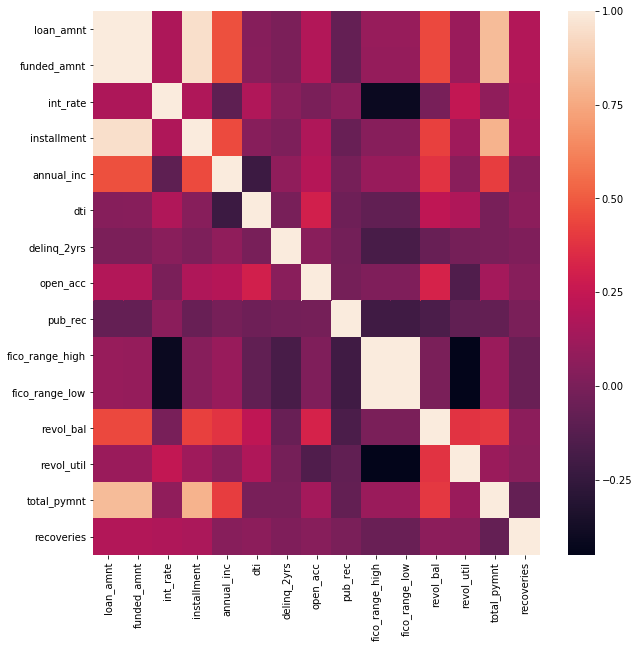

In [76]:
# feature correlation heatmap
import seaborn as sns
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
correlation = final_data_2[cols_to_pick].corr()

sns.heatmap(correlation, ax=ax,
        xticklabels=correlation.columns,
        yticklabels=correlation.columns)
plt.show()

Observations: There seems to be high correlation between total payment and loan amount, funded amount, and installment. There also seems to be high correlation between installment and loan amount and funded amount. 

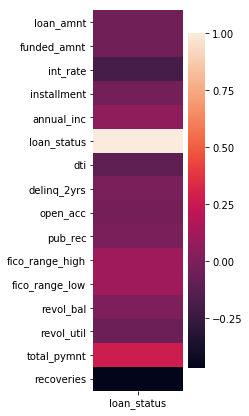

In [77]:
# # Visualize relation between loan status and features
# import seaborn as sns
# sns.pairplot(data=final_data_2, x_vars=float_cols, y_vars='loan_status')

## convert loan status to numerical for creating correlation heatmap
final_data_3 = final_data_2.copy()
final_data_3['loan_status'] = final_data_3['loan_status'].astype('category').cat.codes
# loan status and features correlation heatmap
import seaborn as sns
fig = plt.figure(figsize=(2,7))
ax = fig.add_subplot(1,1,1)
correlation = final_data_3[cols_to_pick].corr()
correlation_2 = correlation['loan_status']
sns.heatmap(correlation_2.to_frame())
plt.show()

As expected, there is high correlation between loan status and total payment. 

What do you observe after removing the outliers?

Naturally, the boxplots are much more readable after removing all outliers greater than 3x the IQR. The median and IQR values can now be clearly seen on the box plot. 

### Data Exploration
Solution to Q.7 from the handout

In [78]:
# Find the percentage of loans by grade, the default by grade,
# and the return of each grade
perc_by_grade = (final_data_2.grade.value_counts()*100/len(final_data_2)).sort_index()

default_by_grade = final_data_2.groupby("grade").apply(lambda x : (x.loan_status != "Fully Paid").sum()*100/len(x) )
ret_by_grade_OPT = final_data_2.groupby('grade').ret_OPT.mean() # average return for M2-Optimistic for each loan grade
ret_by_grade_PESS = final_data_2.groupby('grade').ret_PESS.mean() # average return for M1-Pessimistic for each loan grade
ret_by_grade_INTa = final_data_2.groupby('grade').ret_INTa.mean() # average return for M3
ret_by_grade_INTb = final_data_2.groupby('grade').ret_INTb.mean() # average return for M3
int_rate_by_grade = final_data_2.groupby('grade').int_rate.mean() # average interest rate for each grade

combined = pd.DataFrame(perc_by_grade)
combined.columns = ['perc_of_loans']
combined['perc_default'] = default_by_grade
combined['avg_int_rate'] = int_rate_by_grade
combined['return_OPT'] = ret_by_grade_OPT
combined['return_PESS'] = ret_by_grade_PESS
combined['return_INTa'] = ret_by_grade_INTa
combined['return_INTb'] = ret_by_grade_INTb

combined

,perc_of_loans,perc_default,avg_int_rate,return_OPT,return_PESS,return_INTa,return_INTb
A,15.952659,7.542854,7.220389,0.036266,0.014392,0.019249,0.066183
B,28.603016,15.871365,10.848431,0.044940,0.011624,0.017435,0.064150
C,28.331842,26.145820,14.075877,0.045524,-0.000006,0.009348,0.054754
D,15.765107,34.299118,17.573353,0.047832,-0.005723,0.004528,0.048751
E,7.786171,42.917318,20.809643,0.049539,-0.014714,-0.003508,0.038963
F,2.798943,49.012532,24.592628,0.054053,-0.019375,-0.008814,0.032517
G,0.762262,54.281237,27.312309,0.048185,-0.035448,-0.022557,0.016757


Based on the output of previous cell, write down your answers to Q.7 from the handout.

### Save a Pickle

In [79]:
# Remove the "total_pymnt" and "recoveries" from the list of continuous features
#continuous_features.remove('total_pymnt')
#continuous_features.remove('recoveries')

Why did we remove `total_pymt` and `recoveries` from the data for the task of predicting whether to give loan or not, although these are highly predictive features?

We removed them because we will not have either of these features available to us as investors at the time we actually want to choose a loan to invest in.  They would only be available at the end of the loan.

In [37]:
# save the prepared data for modeling in next Phase.
pickle.dump( [final_data_2, discrete_features, continuous_features, ret_cols], open(pickle_file, "wb") )
#NOTE: this is a 500mb file and thus is not going to be uploaded to our github.